In [1]:
import torch
from torch import nn

In [2]:
from scripts import muat_datasets
from pathlib import Path

data_path = Path('datasets')
train_dir, test_dir = muat_datasets.muat_data(data_path)

Path dataset sudah benar!


In [3]:
train_dir, test_dir

(WindowsPath('datasets/train'), WindowsPath('datasets/test'))

Direktori gambar: datasets\train\red_rot\redrot (143).jpeg
Class gambar: red_rot
Tinggi gambar: 918
Lebar gambar: 750


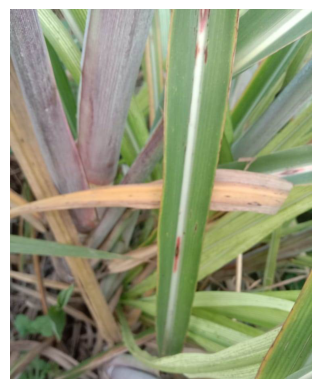

In [4]:
from scripts import visualization

visualization.cek_gambar(data_path)

In [5]:
import torchvision

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
weights = torchvision.models.Swin_V2_B_Weights.DEFAULT
weights

Swin_V2_B_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[256]
    resize_size=[272]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
from torchvision.transforms import v2

In [10]:
train_transform = v2.Compose([
    v2.Resize(size = [256, 256]),
    # v2.Grayscale(num_output_channels = 1),
    v2.AugMix(),
    # v2.TrivialAugmentWide(num_magnitude_bins = 31),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(size = [256, 256]),
    # v2.Grayscale(num_output_channels = 1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [11]:
train_data_loader, test_data_loader, class_names = muat_datasets.dataLoader(train_dir = train_dir,
                                                                            test_dir = test_dir,
                                                                            batch_size = 32, num_workers = 4,
                                                                            train_transform = train_transform,
                                                                            test_transform = test_transform)
train_data_loader, test_data_loader, class_names

Membuat DataLoader dengan ukuran batch 32 dan 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x28c99ab72f0>,
 ['healthy', 'mosaic', 'red_rot', 'rust', 'yellow'])

In [12]:
image_batch, label_batch = next(iter(train_data_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape gambar: torch.Size([3, 256, 256])
Class gambar (bentuk angka): 2


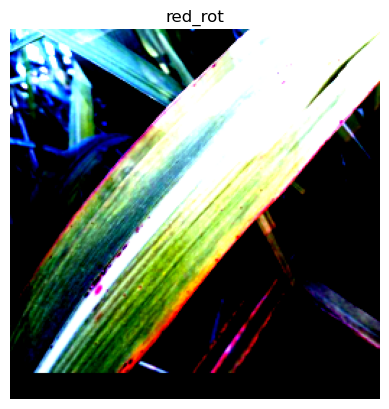

In [13]:
visualization.cek_gambar_dl(image_batch = image_batch, label_batch = label_batch, class_names = class_names)

# SWIN Transformer Step-by-Step

In [14]:
model = torchvision.models.swin_v2_b(weights = weights).to(device)

In [15]:
from torchinfo import summary

In [16]:
summary(model = model, 
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 256, 256]    [32, 1000]           --                   True
├─Sequential (features)                                 [32, 3, 256, 256]    [32, 8, 8, 1024]     --                   True
│    └─Sequential (0)                                   [32, 3, 256, 256]    [32, 64, 64, 128]    --                   True
│    │    └─Conv2d (0)                                  [32, 3, 256, 256]    [32, 128, 64, 64]    6,272                True
│    │    └─Permute (1)                                 [32, 128, 64, 64]    [32, 64, 64, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 64, 64, 128]    [32, 64, 64, 128]    256                  True
│    └─Sequential (1)                                   [32, 64, 64, 128]    [32, 64, 64, 128]    --                   True
│    

In [17]:
for param in model.features.parameters():
    param.requires_grad = False

In [18]:
from scripts import helper

In [19]:
helper.set_seeds()

output_shape = len(class_names)

model.head = torch.nn.Sequential(
    torch.nn.Linear(in_features=1024, 
                    out_features = output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [20]:
summary(model = model, 
        input_size=(32, 3, 256, 256), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 256, 256]    [32, 5]              --                   Partial
├─Sequential (features)                                 [32, 3, 256, 256]    [32, 8, 8, 1024]     --                   False
│    └─Sequential (0)                                   [32, 3, 256, 256]    [32, 64, 64, 128]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 256, 256]    [32, 128, 64, 64]    (6,272)              False
│    │    └─Permute (1)                                 [32, 128, 64, 64]    [32, 64, 64, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 64, 64, 128]    [32, 64, 64, 128]    (256)                False
│    └─Sequential (1)                                   [32, 64, 64, 128]    [32, 64, 64, 128]    --                   Fal

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [22]:
from scripts import engine
# Set the random seeds
helper.set_seeds()

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader = train_data_loader,
                       test_dataloader = test_data_loader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f'Total waktu train: {end_time-start_time:.3f} detik')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1318 | train_acc: 0.5843 | test_loss: 1.0703 | test_acc: 0.6348
Epoch: 2 | train_loss: 0.7449 | train_acc: 0.7720 | test_loss: 0.8621 | test_acc: 0.7082
Epoch: 3 | train_loss: 0.6184 | train_acc: 0.7998 | test_loss: 0.8014 | test_acc: 0.7219
Epoch: 4 | train_loss: 0.5485 | train_acc: 0.8199 | test_loss: 0.8235 | test_acc: 0.6996
Epoch: 5 | train_loss: 0.5198 | train_acc: 0.8312 | test_loss: 0.7778 | test_acc: 0.6977
Epoch: 6 | train_loss: 0.4597 | train_acc: 0.8558 | test_loss: 0.7250 | test_acc: 0.7457
Epoch: 7 | train_loss: 0.4442 | train_acc: 0.8589 | test_loss: 0.6552 | test_acc: 0.7719
Epoch: 8 | train_loss: 0.4249 | train_acc: 0.8672 | test_loss: 0.7246 | test_acc: 0.7480
Epoch: 9 | train_loss: 0.3873 | train_acc: 0.8745 | test_loss: 0.6706 | test_acc: 0.7707
Epoch: 10 | train_loss: 0.3744 | train_acc: 0.8753 | test_loss: 0.6657 | test_acc: 0.7777
Epoch: 11 | train_loss: 0.3814 | train_acc: 0.8745 | test_loss: 0.6578 | test_acc: 0.7824
Epoch: 12 | train_l

In [23]:
PATH = Path('model')
MODEL_NAME = 'SwinV2_daun_tebu_AugMix_Norm.pth'

SAVE_PATH = PATH/MODEL_NAME

In [24]:
print(f'Saving model to: {SAVE_PATH}')
torch.save(obj = model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f = SAVE_PATH)

Saving model to: model\SwinV2_daun_tebu_AugMix_Norm.pth


In [25]:
custom_img_path = Path('datasets/test/healthy/healthy (11).jpeg')

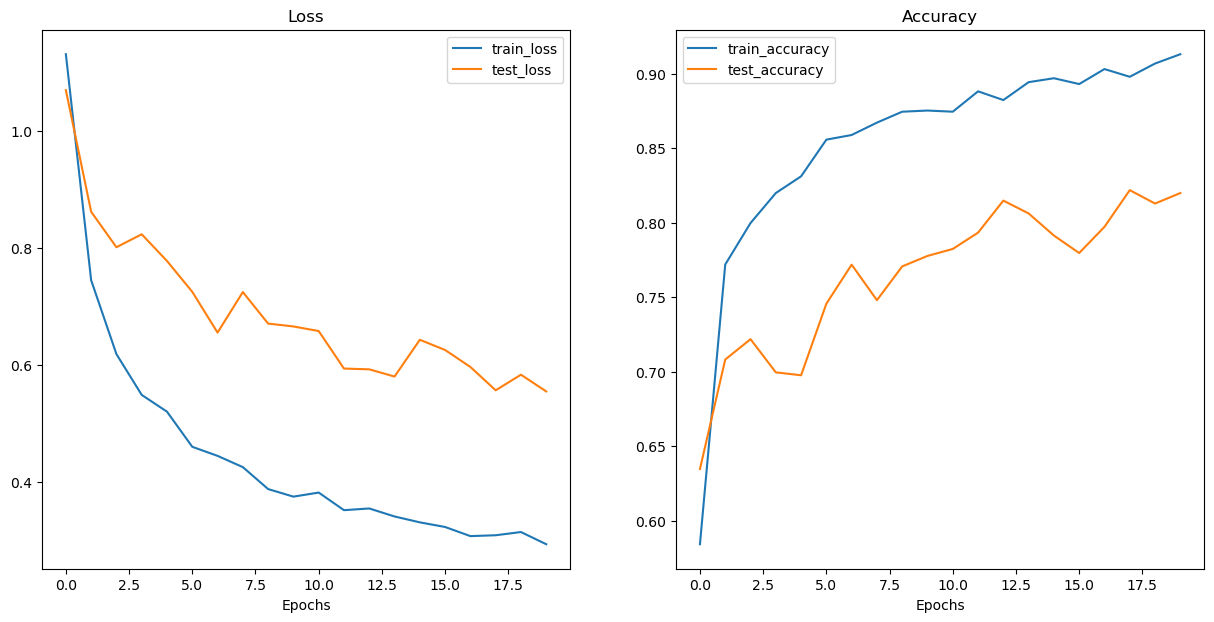

In [26]:
from scripts import prediksi
prediksi.plot_grafik_loss(results)

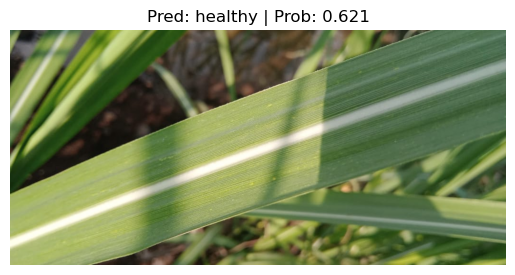

In [27]:
prediksi.pred_gambar(model = model,
                image_path = custom_img_path,
                class_names=class_names,
                transform = test_transform,
                device = device)

  0%|          | 0/16 [00:00<?, ?it/s]

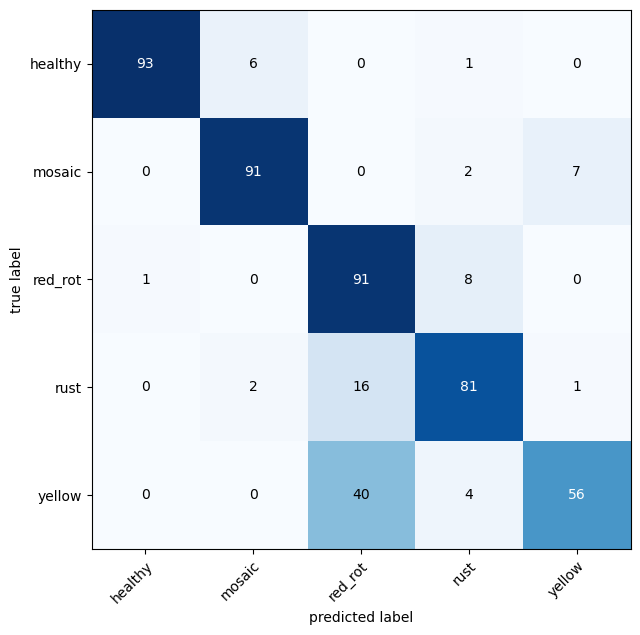

In [28]:
prediksi.confusion_matrix(
    model = model,
    test_dataloader = test_data_loader,
    device = device,
    class_names = class_names
)